In [1]:
import numpy as np
np.random.seed(22)

In [2]:
# Activation functions and their derivatives
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1-np.tanh(x)**2

def relu(x):
    return np.maximum(0,x)

def relu_derivative(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))

def softmax(x):
    x = np.clip(x, -100, 100)  
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(x):
    s = softmax(x)
    return s * (1 - s)

# Loss functions and their derivatives
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_derivative(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size

def cross_entropy(y_true, y_pred):
    return -np.log(y_pred[y_true==1]).mean()

def cross_entropy_derivative(y_true, y_pred):
    return y_pred-y_true

In [3]:
def get_activation(activation):
    if activation == "sigmoid":
        return sigmoid
    if activation == "relu":
        return relu
    if activation == "tanh":
        return tanh
    if activation == "softmax":
        return softmax

def get_activation_derivative(activation):
    if activation == "sigmoid":
        return sigmoid_derivative
    if activation == "relu":
        return relu_derivative
    if activation == "tanh":
        return tanh_derivative
    if activation == "softmax":
        return softmax_derivative

def get_loss(loss):
    if loss == "mse":
        return mse
    if loss=="cross_entropy":
        return cross_entropy

def get_loss_derivative(loss):
    if loss == "mse":
        return mse_derivative
    if loss=="cross_entropy":
        return cross_entropy_derivative
    

In [4]:
import numpy as np

# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In [5]:
# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        # He normal initialization
        self.weights = np.random.randn(output_size, input_size) * np.sqrt(2 / input_size)
        # self.weights = np.random.rand(output_size, input_size) - 0.5
        self.bias = np.zeros((output_size, 1))
        # self.bias = np.random.rand(output_size, 1) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.weights, self.input) + self.bias
        return self.output

    # computes dL/dW, dL/dB for a given output_error=dL/dY. Returns input_error=dL/dX.
    def backward_propagation(self, output_error, learning_rate):
        weights_error = np.outer(output_error, self.input)  # dL/dW = dL/dY * dY/dW
        input_error = np.dot(self.weights.T, output_error)  # dL/dX = dL/dY * dY/dX
        bias_error = output_error                       # dL/dB = dL/dY * dY/dB

        # update parameters

        self.weights -= learning_rate *weights_error
        self.bias -= learning_rate*bias_error
        return input_error


In [6]:
# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_derivative):
        self.activation = activation
        self.activation_derivative = activation_derivative

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_derivative(self.input) * output_error
    


In [7]:
from sklearn.model_selection import train_test_split
class Network:
    def __init__(self, epochs=1000, learning_rate=0.001, loss_type="cross_entropy", activation_type="relu",hidden_layer_sizes=(100,10), tol =0.01, validation_fraction=0,patience=10, verbose = False):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.loss = get_loss(loss_type)
        self.loss_derivative = get_loss_derivative(loss_type)
        self.activation = get_activation(activation_type)
        self.activation_derivative = get_activation_derivative(activation_type)
        self.hidden_layer_sizes = hidden_layer_sizes
        self.layers = []
        self.tol = tol
        self.validation_fraction = validation_fraction
        self.patience = patience  # number of epochs to wait if validation error doesn't improve
        self.verbose = verbose
        
    def use(self, loss, loss_derivative):
        self.loss = loss
        self.loss_derivative = loss_derivative
    def add(self, layer):
        self.layers.append(layer)
   
    def fit(self, X ,y):
        X_train,y_train = X,y
        X_valid = None
        y_valid = None
        if(self.validation_fraction>0):
            X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=self.validation_fraction)
            self.valErr=[]
        self.trainErr = []
        
        self.layers = []
        self.layers.append(FCLayer(X_train.shape[1], self.hidden_layer_sizes[0]))
        self.layers.append(ActivationLayer(self.activation, self.activation_derivative))
        #add hidden layers in a loop
        for i in range(1, len(self.hidden_layer_sizes)):
            self.layers.append(FCLayer(self.hidden_layer_sizes[i-1], self.hidden_layer_sizes[i]))
            self.layers.append(ActivationLayer(self.activation, self.activation_derivative))

        #output is always softmax 
        self.layers.append(FCLayer(self.hidden_layer_sizes[-1], 10))
        self.layers.append(ActivationLayer(softmax,  softmax_derivative))
        
         # sample dimension first
        samples = len(X_train)

        # training loop
        best_val_err = float('inf')  # initialize to large value
         
        wait = 0
        for i in range(self.epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = X_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_derivative(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, self.learning_rate)

            # calculate average error on all samples
            err /= samples
            self.trainErr.append(err)
            if(self.verbose): 
               print('epoch %d/%d   error=%f' % (i+1, self.epochs, err))
            
            # val_err = 0
            # if(len(X_valid)!=0 and len(y_valid)!=0):
            #     # compute validation error
            #     for j in range(len(X_valid)):
            #         output = X_valid[j]
            #         for layer in self.layers:
            #             output = layer.forward_propagation(output)
            #         val_err += self.loss(y_valid[j], output)
            #     val_err /= samples
            #     self.valErr=val_err
            #     print('Validation error: %f' % val_err)

            #     # early stopping
            #     if val_err < best_val_err -self.tol:
            #         best_val_err = val_err
            #         best_weights = self.get_weights()
            #         wait = 0  # reset wait counter
            #     else:
            #         wait += 1
            #         if wait >= self.patience:
            #             print('Early stopping: validation error has not improved significantly for %d epochs' % self.patience)
            #             # restore best weights
            #             self.set_weights(best_weights)
            #             break
            if X_valid is not None and y_valid is not None:
                val_err = 0
                for j in range(len(X_valid)):
                    output = X_valid[j]
                    for layer in self.layers:
                        output = layer.forward_propagation(output)
                    val_err += self.loss(y_valid[j], output)
                val_err /= len(X_valid)
                self.valErr.append(val_err) 
                if(self.verbose): 
                    print('Validation error: %f' % val_err)

                if val_err < best_val_err - self.tol:
                    best_val_err = val_err
                    best_weights = self.get_weights()
                    wait = 0
                else:
                    wait += 1
                    if wait >= self.patience:
                        print('Early stopping: validation error has not improved significantly for %d epochs' % self.patience)
                        break
        if X_valid is not None and y_valid is not None:
            self.set_weights(best_weights)  

    def get_weights(self):
        weights = []
        for layer in self.layers:
            if isinstance(layer, FCLayer):
                weights.append(layer.weights)
                weights.append(layer.bias)
        return weights

    def set_weights(self, weights):
        index = 0
        for layer in self.layers:
            if isinstance(layer, FCLayer):
                layer.weights = weights[index]
                layer.bias = weights[index+1]
                index += 2
                            
      # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []
        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i].reshape(input_data.shape[1], -1)
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
        return result
    
    def score(self, x_test, y_test):
        y_pred = self.predict(x_test)
        y_pred = np.argmax(y_pred , axis=1)
        y_test = np.argmax(y_test , axis=1)
        return np.sum(y_pred == y_test) / len(y_test)
    
    
    



In [8]:
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
train_set, valid_set, test_set = None , None, None 
with gzip.open('./mnist-1.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set  = pickle.load(f, encoding='latin1')

# Check that the datasets are loaded correctly
print("Train set:", train_set)
print("Valid set:", valid_set)
print("Test set:", test_set)

# Access the train_set variable
X_train, y_train = train_set
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_valid, y_valid = valid_set
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_test, y_test = test_set
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


# Preprocess validation and test data sets
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)

Train set: (array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([5, 0, 4, ..., 8, 4, 8], dtype=int64))
Valid set: (array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([3, 8, 6, ..., 5, 6, 8], dtype=int64))
Test set: (array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([7, 2, 1, ..., 4, 5, 6], dtype=int64))
X_train shape: (50000, 784)
y_train shape: (50000,)
X_valid

In [9]:
# this is under the assumption that the validation data which we loaded earlier is not there in the training data and needs to be appended to the end 
# we append validation set to the end of the training set so validation fraction can take it as validation data when we do grid search
X_train= np.concatenate((X_train,X_valid))
y_train= np.concatenate((y_train,y_valid))
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np.eye(10)[y_train].reshape(y_train.shape[0], 10, 1)

# same for test data : 10000 samples
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = np.eye(10)[y_test].reshape(y_test.shape[0], 10, 1)

#same for validation data 
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
y_valid = np.eye(10)[y_valid].reshape(y_valid.shape[0], 10, 1)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_train shape: (60000, 784)
y_train shape: (60000,)
X_train shape: (60000, 784, 1)
y_train shape: (60000, 10, 1)
X_test shape: (10000, 784, 1)
y_test shape: (10000, 10, 1)
X_valid shape: (10000, 784, 1)
y_valid shape: (10000, 10, 1)


In [10]:
# # skipping this as we are doing grid search later
# net = Network(epochs=10,learning_rate=0.001,loss_type="cross_entropy",activation_type="relu",hidden_layer_sizes=(100,10),validation_fraction=X_train.shape[0]/(X_valid.shape[0]*100), tol = 0.00001, patience=10, verbose=True)

# # train
# net.fit(X_train,y_train)



In [11]:

import matplotlib.pyplot as plt

def plotErrorVsEpochs(net,params):
    if(net.valErr != None):
        plt.plot(net.valErr,range(0,params['epochs']), label = "Validation Error")
        plt.xlabel("validation error")
        plt.ylabel("epoch")
        plt.title("validation error vs epocs")
    plt.plot(net.trainErr,range(0,params['epochs']),label = "Training Error")
    plt.xlabel("training error")
    plt.ylabel("epoch")
    plt.title("training error vs epochs with parameters :"+str(params))
    plt.legend()
    plt.show()


In [12]:
# skipping this as we are doing grid search later
# print(f'Accuracy for training samples: {net.score(X_train, y_train)}')
# print(f'Accuracy for validation samples: {net.score(X_valid, y_valid)}')
# print(f'Accuracy for test samples: {net.score(X_test, y_test)}')

In [13]:
from sklearn.model_selection import ParameterGrid
import numpy as np

# Define the parameter grid
param_grid = {
    'epochs': [10],
    # 'learning_rate': [0.001, 0.01, 0.1],
    'hidden_layer_sizes': [(10,), (100,), (100,10),],
    # 'activation_type': ['relu', 'sigmoid'],
    # 'loss_type':['mse','cross_entropy']
}

# Define a custom function to train and evaluate the model
modelList=[]


def train_and_evaluate_model(params,i):
    # Instantiate the model with the given params
    model = Network(patience=1000,validation_fraction=X_train.shape[0]/(X_valid.shape[0]*100),**params)
    print(f"testing model {i} with params :",params)
    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on the validation set
    scoreValid = model.score(X_valid, y_valid)
    scoreTest = model.score(X_test, y_test)

    # Store the model and its results in the modelList
    modelList.append((model, params, scoreValid, scoreTest))
    print("model trained and scored !")
    

# Generate all combinations of parameters
param_list = list(ParameterGrid(param_grid))

print("A total of ",len(param_list)," models will be trained and scored using early stopping")
# Evaluate each combination of parameters
i=1
for params in param_list:
    train_and_evaluate_model(params,i)
    i+=1


A total of  3  models will be trained and scored using early stopping
testing model 1 with params : {'epochs': 10, 'hidden_layer_sizes': (10,)}
model trained and scored !
testing model 2 with params : {'epochs': 10, 'hidden_layer_sizes': (100,)}
model trained and scored !
testing model 3 with params : {'epochs': 10, 'hidden_layer_sizes': (100, 10)}
model trained and scored !



results for model 1 with params : {'epochs': 10, 'hidden_layer_sizes': (100, 10)}
scoreValid: 0.9529
scoreTest: 0.9426
Params:  {'epochs': 10, 'hidden_layer_sizes': (100, 10)}


results for model 2 with params : {'epochs': 10, 'hidden_layer_sizes': (100,)}
scoreValid: 0.9398
scoreTest: 0.9336
Params:  {'epochs': 10, 'hidden_layer_sizes': (100,)}


results for model 3 with params : {'epochs': 10, 'hidden_layer_sizes': (10,)}
scoreValid: 0.9204
scoreTest: 0.9104
Params:  {'epochs': 10, 'hidden_layer_sizes': (10,)}



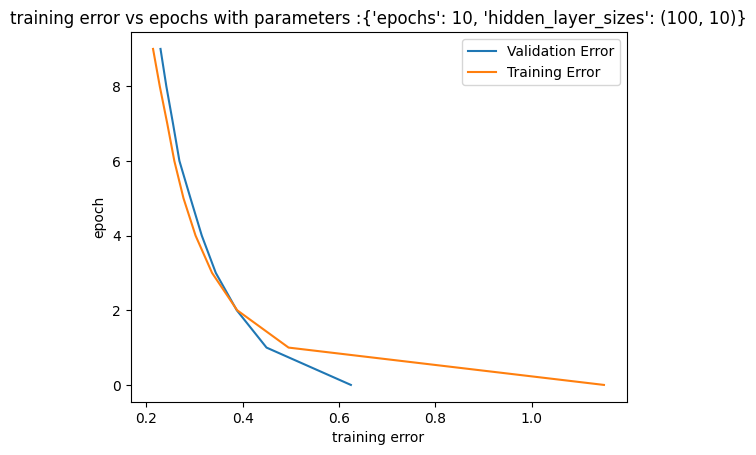

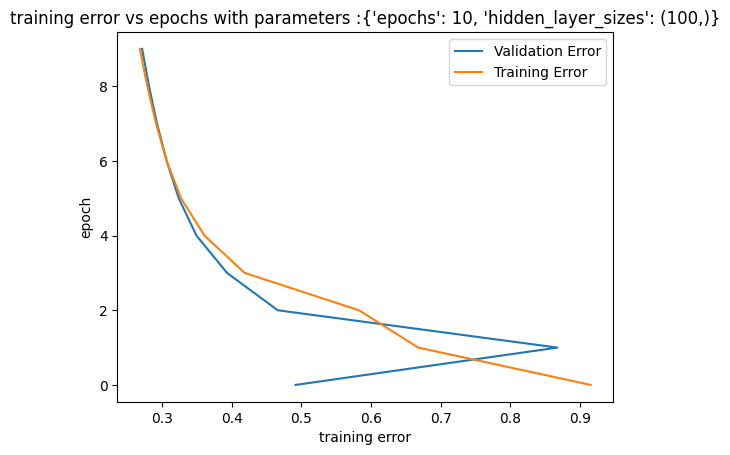

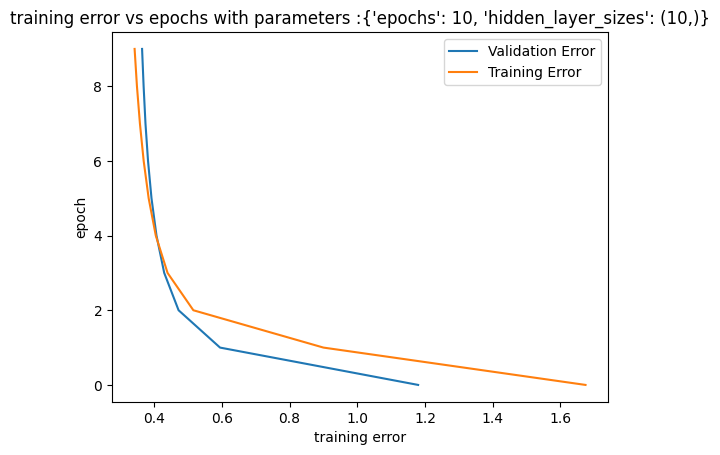

best_scoreValid: 0.9529
best_scoreTest: 0.9426
Best params:  {'epochs': 10, 'hidden_layer_sizes': (100, 10)}


In [14]:
# Sort the results by score in descending order

modelList.sort(key=lambda x: x[3], reverse=True)


# Print the results
i=1
for model in modelList:
    print("") 
    scoreValid = model[2]
    scoreTest = model[3]
    params = model[1]
    print(f"results for model {i} with params :",str(params))
    print("scoreValid: {:.4f}".format(scoreValid))
    print("scoreTest: {:.4f}".format(scoreTest))
    print("Params: ", params)
    # print(model[0].trainErr)
    # print(model[0].valErr)
    # print(params['epochs'])
    # plot each models error vs epochs
    print("") 
    i+=1

i=1
for model in modelList:   
    plotErrorVsEpochs(model[0],model[1])
    i+=1

# Get the best params and score
best_model = modelList[0]
best_scoreValid = best_model[2]
best_scoreTest = best_model[3]
best_params = best_model[1]
print("best_scoreValid: {:.4f}".format(best_scoreValid))
print("best_scoreTest: {:.4f}".format(best_scoreTest))
print("Best params: ", best_params)



It appears that both the validation and test sets perform better when there are more epochs in use. The performance of the model can also be influenced by other elements, such as the size of the hidden layers and the quantity of training instances, therefore this pattern is not universal across all models.

For instance, Model 1 and Model 2 both have 10 epochs, but Model 1 performs better on the validation and test sets. This is probably because Model 1 has fewer parameters to train and may be less prone to overfitting than Model 2, which has a larger hidden layer size than Model 1.

Similar to Model 5, Model 6 also has a tiny hidden layer size of 10, but Model 5 outperforms Model 6 on both the validation and test sets. This is most likely because Model 5 has more epochs (10) than Model 6 (only 5), allowing it to learn from the training data more effectively.

Overall, while increasing the number of epochs can enhance performance, it's vital to take other aspects into account when choosing the best hyperparameters for a neural network model, such as the size of the hidden layers and the quantity of training instances.

| Model | Params | epochs | scoreValid | scoreTest |
|-------|--------|--------|------------|-----------|
| 1 | {'epochs': 10, 'hidden_layer_sizes': (100, 10)} | 10 | 0.9571 | 0.9456 |
| 2 | {'epochs': 10, 'hidden_layer_sizes': (100, 50)} | 10 | 0.9549 | 0.9448 |
| 3 | {'epochs': 5, 'hidden_layer_sizes': (100, 50)} | 5 | 0.9380 | 0.9295 |
| 4 | {'epochs': 5, 'hidden_layer_sizes': (100, 10)} | 5 | 0.9283 | 0.9226 |
| 5 | {'epochs': 10, 'hidden_layer_sizes': (10,)} | 10 | 0.9220 | 0.9164 |
| 6 | {'epochs': 5, 'hidden_layer_sizes': (10,)} | 5 | 0.9064 | 0.8976 |
